In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from torch import nn


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 16
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]

config = Config()
len(Config.TARGET_COLS)

11

In [4]:
torch.manual_seed(Config.SEED)

# Loading Data

In [5]:
BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-v2-dataset"

In [6]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(10)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
5,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,367,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
6,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,368,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
7,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,369,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
8,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,370,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
9,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,371,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


In [7]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [8]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

# Torch Dataloader with Augmentation

In [9]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

class CustomDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define any image transformations you want to apply, here we also add augmentation. 
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(256),   # Random crop and resize
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Converting Dataframe to Dataloader

In [10]:
# get image_paths and labels
print("[INFO] Building the dataset...")

train_paths  = train_data.image_path.tolist()
train_labels = train_data[config.TARGET_COLS].values

val_paths  = val_data.image_path.tolist()
val_labels = val_data[config.TARGET_COLS].values


#torch dataset
batch_size = 32

# Create the datasets

dataset_train = CustomDataset(train_paths, train_labels, transform=transform)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


dataset_val = CustomDataset(val_paths, val_labels, transform=transform)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


# Define your dataset size and other configuration parameters
dataset_size = len(dataset_train)  # Assuming you have defined 'dataset' earlier
batch_size = 32  # Your batch size
total_epochs = 50  # Total number of epochs

# Calculate total train steps
total_train_steps = dataset_size * batch_size * total_epochs

# Define warmup steps as 10% of total train steps
warmup_steps = int(total_train_steps * 0.10)

# Define decay steps as the remaining steps after warmup
decay_steps = total_train_steps - warmup_steps

print(f"Total Train Steps: {total_train_steps}")
print(f"Warmup Steps: {warmup_steps}")
print(f"Decay Steps: {decay_steps}")

[INFO] Building the dataset...
Total Train Steps: 15379200
Warmup Steps: 1537920
Decay Steps: 13841280


In [11]:
for img, label in train_dataloader:
  print(img.shape)
  break

torch.Size([32, 3, 256, 256])


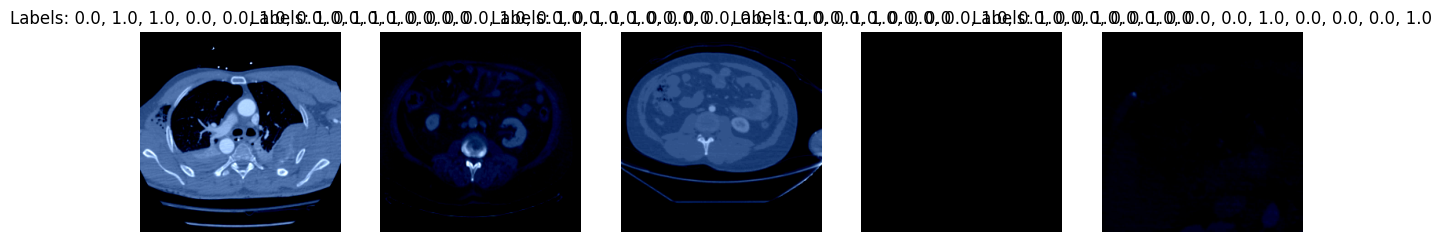

In [12]:
#a function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for displaying
        axes[idx].imshow(image)
        label_str = ", ".join([str(val) for val in label])  # Convert label tensor to string
        axes[idx].set_title(f"Labels: {label_str}")
        axes[idx].axis("off")
    plt.show()

# Load a few images for visualization
num_images_to_display = 5
sample_indices = torch.randint(len(dataset_train), size=(num_images_to_display,))
sample_images = [dataset_train[i][0] for i in sample_indices]
sample_labels = [dataset_train[i][1] for i in sample_indices]

# Convert label tensors to numpy arrays for display
sample_labels_np = [label.numpy() for label in sample_labels]

# Display the sample images
show_images(sample_images, sample_labels_np)


## Simple CNN

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = SimpleCNN(num_classes=11).to('cuda')

## Training the Model

In [14]:
import torch
import torch.nn as nn


# Instantiate the model
model = SimpleCNN(num_classes=11).to('cuda')

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

total_epochs = 25  # Replace with the total number of epochs


train_losses = []  # To store training losses
val_losses = []    # To store validation losses
val_accuracies = []  # To store validation accuracies

for epoch in range(total_epochs):
    model.train()  # Set the model to training mode
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        
        # Move data to GPU
        images = images.to('cuda')
        labels = labels.to('cuda')
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
    
    # Update learning rate using the scheduler
    scheduler.step()
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            
            predicted = (outputs > 0.5).int()  # Convert logits to binary predictions
            total += labels.size(0) * labels.size(1)  # Total number of predictions
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_dataloader)
    val_accuracy = 100.0 * correct / total
    
     # Append loss and accuracy values to lists
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{total_epochs}] - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")


Epoch [1/25] - Loss: 0.3409 - Val Loss: 0.4170 - Val Acc: 80.65%
Epoch [2/25] - Loss: 0.3279 - Val Loss: 0.4046 - Val Acc: 81.27%
Epoch [3/25] - Loss: 0.4167 - Val Loss: 0.4016 - Val Acc: 81.76%
Epoch [4/25] - Loss: 0.3415 - Val Loss: 0.3935 - Val Acc: 81.75%
Epoch [5/25] - Loss: 0.4620 - Val Loss: 0.3899 - Val Acc: 82.03%
Epoch [6/25] - Loss: 0.4056 - Val Loss: 0.3924 - Val Acc: 81.89%
Epoch [7/25] - Loss: 0.4349 - Val Loss: 0.3886 - Val Acc: 81.99%
Epoch [8/25] - Loss: 0.4270 - Val Loss: 0.3904 - Val Acc: 81.70%
Epoch [9/25] - Loss: 0.3708 - Val Loss: 0.3913 - Val Acc: 81.70%
Epoch [10/25] - Loss: 0.5631 - Val Loss: 0.3869 - Val Acc: 82.49%
Epoch [11/25] - Loss: 0.3101 - Val Loss: 0.3829 - Val Acc: 82.61%
Epoch [12/25] - Loss: 0.4407 - Val Loss: 0.3787 - Val Acc: 82.55%
Epoch [13/25] - Loss: 0.3520 - Val Loss: 0.3707 - Val Acc: 82.85%
Epoch [14/25] - Loss: 0.3828 - Val Loss: 0.3684 - Val Acc: 83.04%
Epoch [15/25] - Loss: 0.3823 - Val Loss: 0.3670 - Val Acc: 83.14%
Epoch [16/25] - Los

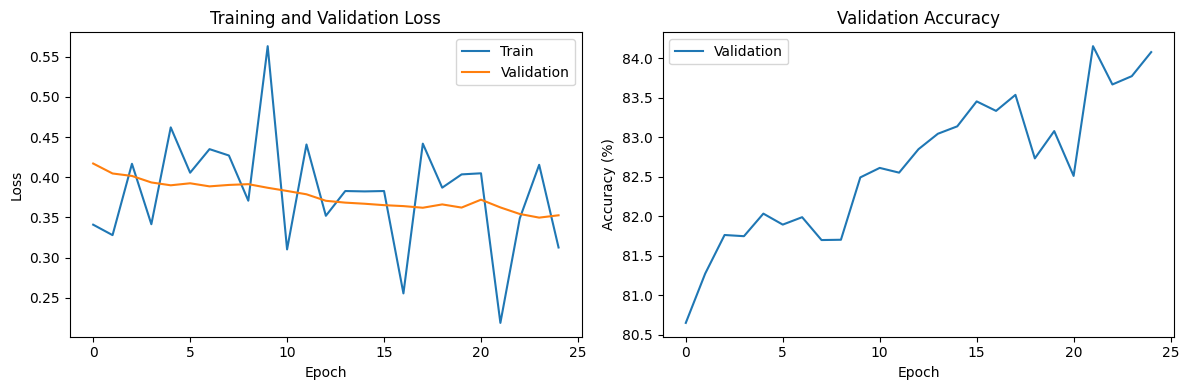

In [15]:
# Plot training and validation progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

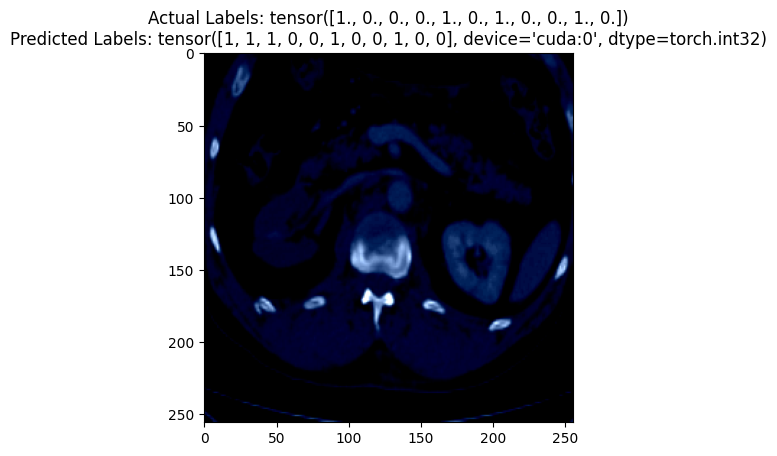

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Select a random image from the validation dataset
random_index = np.random.randint(len(dataset_val))
image, label = dataset_val[random_index]

# Move the image to the GPU if available
image = image.to('cuda')

# Pass the image through the model
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Unsqueeze to add batch dimension

# Convert the output logits to probabilities using sigmoid function
predicted_probs = torch.sigmoid(output)[0]

# Convert predicted probabilities to binary predictions
predicted_labels = (predicted_probs > 0.5).int()


# Display the image, actual labels, and predicted labels
plt.imshow(image.permute(1, 2, 0).cpu())  # Move image to CPU and change channel order
#plt.title(f"Actual Labels: {label}\nPredicted Labels: {predicted_labels}")
plt.title(f"Actual Labels: {label}\nPredicted Labels: {predicted_labels}")
plt.show()